### Package import and Data Loading

In [1]:
## !git clone https://github.com/fedighanmi/The-Effect-of-BatchNorm-on-NN.git
## %cd The-Effect-of-BatchNorm-on-NN


Cloning into 'The-Effect-of-BatchNorm-on-NN'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 18 (delta 5), reused 15 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 219.88 KiB | 10.47 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/The-Effect-of-BatchNorm-on-NN


torch.Size([64, 3, 32, 32]) torch.Size([64])


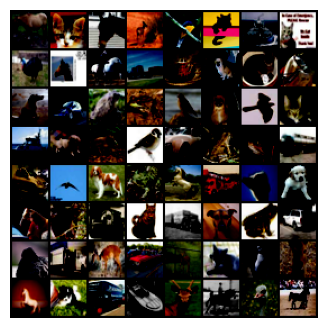

CIFAR-10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import GaussianBlur
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from utils import *


batch_size = 64

# Define transform — converts to tensor and normalizes RGB values
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor [0,1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize RGB channels
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Visualize a batch
x, y = next(iter(train_loader))
print(x.shape, y.shape)   # Expected: torch.Size([64, 3, 32, 32])

# Convert grid of images to numpy for plotting
npimg = torchvision.utils.make_grid(x).numpy()
plt.figure(figsize=(8, 4))
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.axis('off')
plt.show()

# Print class names
print("CIFAR-10 classes:", train_dataset.classes)


### Model Definition, Running and Results:

In [3]:
# Hyperparameters
learning_rate = 0.001
epochs = 10

# ---- Model without BatchNorm ----
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(

            nn.Conv2d(3, 16, kernel_size= 5, padding= 2, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2), # -> (64, 4, 4)
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(64*4*4, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

# ---- Model with BatchNorm ----
class NN_BN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(

            nn.Conv2d(3, 16, kernel_size= 5, padding= 2, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2), # -> (64, 4, 4)
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(64*4*4, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)


criterion = nn.CrossEntropyLoss()

model_no_bn = NN()
optimizer_1 = torch.optim.SGD(model_no_bn.parameters(), lr=learning_rate)

model_bn = NN_BN()
optimizer_2 = torch.optim.SGD(model_bn.parameters(), lr=learning_rate)


In [ ]:
# Train model without BatchNorm
loss_no_bn, acc_no_bn = train_model(model_no_bn, optimizer_1, criterion, train_loader, test_loader, epochs)


In [ ]:
# Train model with BatchNorm
loss_bn, acc_bn = train_model(model_bn, optimizer_2, criterion, train_loader, test_loader, epochs)

In [ ]:
plot_compare_training_curves(
    loss_bn=loss_bn,
    loss_no_bn=loss_no_bn,
    acc_bn=acc_bn,
    acc_no_bn=acc_no_bn,
    epochs=epochs
)


In [ ]:
# Batch Normalized Results.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images = generate_images_for_all_classes(model_bn.to(device), device , train_dataset.classes)

In [ ]:
# Non-Batch Normalized Results.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images = generate_images_for_all_classes(model_bn.to(device), device , train_dataset.classes)